In [1]:
import sys,os,glob,copy
sys.path.append('../')
import numpy as np
from numpy.linalg import norm
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.interpolate import LinearNDInterpolator,interp2d
import matplotlib as mpl
from matplotlib.colors import LogNorm
from IPython.display import display, Markdown
from collections import OrderedDict
import pylhe
import glob
import pyslha

delphesDir = os.path.abspath("../../MG5/Delphes")
os.environ['ROOT_INCLUDE_PATH'] = os.path.join(delphesDir,"external")

import ROOT
import xml.etree.ElementTree as ET


ROOT.gSystem.Load(os.path.join(delphesDir,"libDelphes.so"))

ROOT.gInterpreter.Declare('#include "classes/SortableObject.h"')
ROOT.gInterpreter.Declare('#include "classes/DelphesClasses.h"')
ROOT.gInterpreter.Declare('#include "external/ExRootAnalysis/ExRootTreeReader.h"')

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')

Welcome to JupyROOT 6.26/10


In [2]:
inputFiles = {'Axial_noBias': '../../MG5/DMSimp_axial_OnShell/Events/run_01/noBias_delphes_events.root',
              'Vector_noBias': '../../MG5/DMSimp_vector_OnShell/Events/run_01/noBias_delphes_events.root'}

In [3]:
parameters = {}
for label,file in inputFiles.items():
    banner = sorted(glob.glob(os.path.dirname(file)+'/*banner.txt'),key=os.path.getmtime,reverse=True)
    if len(banner) == 0:
        print('Banner not found for %s' %label)
    elif len(banner) > 1:        
        print('\n%i banner files found for %s. Using %s' 
              %(len(banner),label,os.path.basename(banner[0])))
    banner = banner[0]
    xtree = ET.parse(banner)
    xroot = xtree.getroot()
    xsecPB = eval(xroot.find('init').text.split()[-2])
    slha = xroot.find('header').find('slha').text
    pars = pyslha.readSLHA(slha)
    mMed = pars.blocks['MASS'][55]
    mDM = pars.blocks['MASS'][52]
    gVq = pars.blocks['DMINPUTS'][4] # Mediator-quark vector coupling
    gAq = pars.blocks['DMINPUTS'][10] # Mediator-quark axial coupling
    gVx = pars.blocks['DMINPUTS'][2] # Mediator-DM vector coupling
    gAx = pars.blocks['DMINPUTS'][3] # Mediator-DM axial coupling
    parameters[label] = {'xsec(pb)' : xsecPB, 'mMed' : mMed, 'mDM' : mDM, 
                         'gVq' : gVq, 'gAq' : gAq, 'gVx' : gVx, 'gAx' : gAx}
    print(label,': mMed = %1.2f GeV, mDM = %1.2f GeV, cross-section = %1.3e pb' %(mMed,mDM,xsecPB))


Axial_noBias : mMed = 2000.00 GeV, mDM = 1.00 GeV, cross-section = 5.103e-01 pb
Vector_noBias : mMed = 2000.00 GeV, mDM = 1.00 GeV, cross-section = 5.103e-01 pb


In [4]:
# Store Z' met and jet pt before event selection

pTj1 = {label : np.array([]) for label in inputFiles}
weights = {label : np.array([]) for label in inputFiles}
met = {label : np.array([]) for label in inputFiles}
genMet = {label : np.array([]) for label in inputFiles}
totalweight = {label : 0.0 for label in inputFiles}

    
for label,inputFile in inputFiles.items():

    f = ROOT.TFile(inputFile,'read')
    tree = f.Get("Delphes")
    nevts = tree.GetEntries()
    parameters[label]['Events'] = nevts
    
    for ievt in range(nevts):    
        tree.GetEntry(ievt)        
        weight = tree.Weight.At(1).Weight # Correct weight when using matching

        totalweight[label] += weight

        missingET = tree.MissingET.At(0) # MET (detector level)
        genMissingET = tree.GenMissingET.At(0)  # MET (parton level)
        
#         if missingET.MET < 250.:
#             continue     
            
#         if genMissingET.MET < 250.:
#             continue
        
        weights[label] = np.append(weights[label],weight)
        met[label] = np.append(met[label],missingET.MET)
        genMet[label] = np.append(genMet[label],genMissingET.MET)

    f.Close()

In [12]:
for label,w in totalweight.items():
    print(label,'total cross-section = %1.3e pb (%i events)' %(w,parameters[label]['Events']))
colors = {label : sns.color_palette('deep')[i+1] for i,label in enumerate(weights.keys())}    

Axial_noBias total cross-section = 5.103e-01 pb (100000 events)
Vector_noBias total cross-section = 5.103e-01 pb (100000 events)


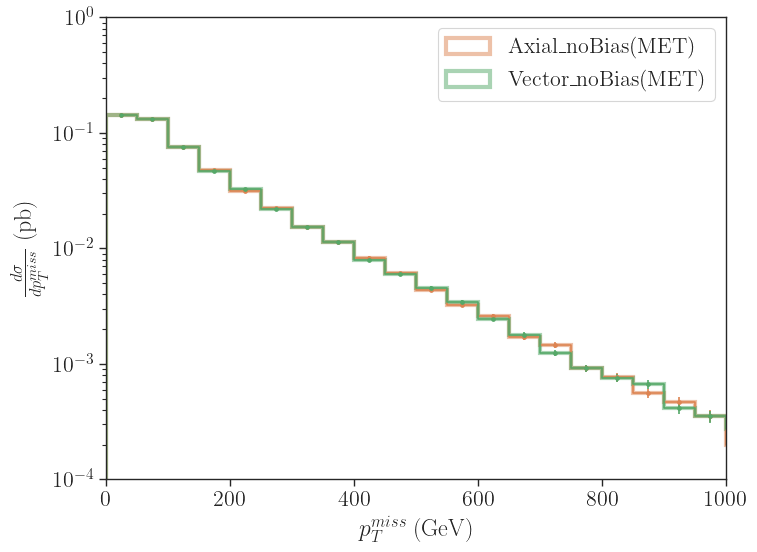

In [13]:
fig1 = plt.figure(figsize=(8,6))
plotError = True
for label,metPts in met.items():
    binc,binEdges,patches = plt.hist(metPts,bins=np.arange(0.,2000.,50.),
                               label=label+'(MET)',histtype='step',
                               weights=weights[label],linewidth=3,alpha=0.5, color=colors[label])
    
    if plotError:
        errorc2,_ = np.histogram(metPts,bins=binEdges,weights=weights[label]**2)
        errorc = np.sqrt(errorc2)
        binMid = (binEdges[0:-1]+binEdges[1:])/2.
        plt.errorbar(binMid,binc,yerr = errorc, marker = '.', 
                     drawstyle = 'steps-mid',color=colors[label])
       
        
plt.yscale('log')
plt.ylim(1e-4,1e0)
plt.xlabel(r'$p_T^{miss}$ (GeV)')
plt.ylabel(r'$\frac{d\sigma}{d p_T^{miss}}$ (pb)')
plt.xlim(0,1000)
plt.legend()
plt.show()

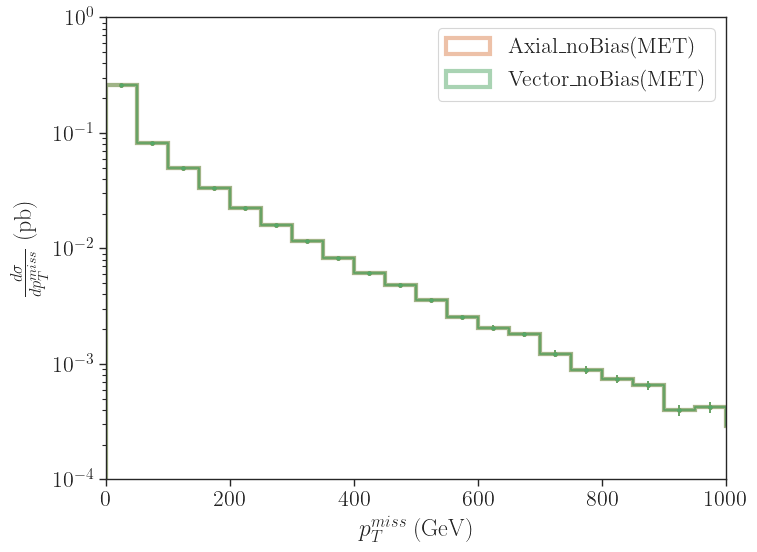

In [14]:
fig2 = plt.figure(figsize=(8,6))
plotError = True
for label,metPts in genMet.items():
    binc,binEdges,patches = plt.hist(metPts,bins=np.arange(0.,2000.,50.),
                               label=label+'(MET)',histtype='step',
                               weights=weights[label],linewidth=3,alpha=0.5,color=colors[label])
    
    if plotError:
        errorc2,_ = np.histogram(metPts,bins=binEdges,weights=weights[label]**2)
        errorc = np.sqrt(errorc2)
        binMid = (binEdges[0:-1]+binEdges[1:])/2.
        plt.errorbar(binMid,binc,yerr = errorc, marker = '.', 
                     drawstyle = 'steps-mid',color=colors[label])
       
        
plt.yscale('log')
plt.ylim(1e-4,1e0)
plt.xlabel(r'$p_T^{miss}$ (GeV)')
plt.ylabel(r'$\frac{d\sigma}{d p_T^{miss}}$ (pb)')
plt.xlim(0,1000)
plt.legend()
plt.show()

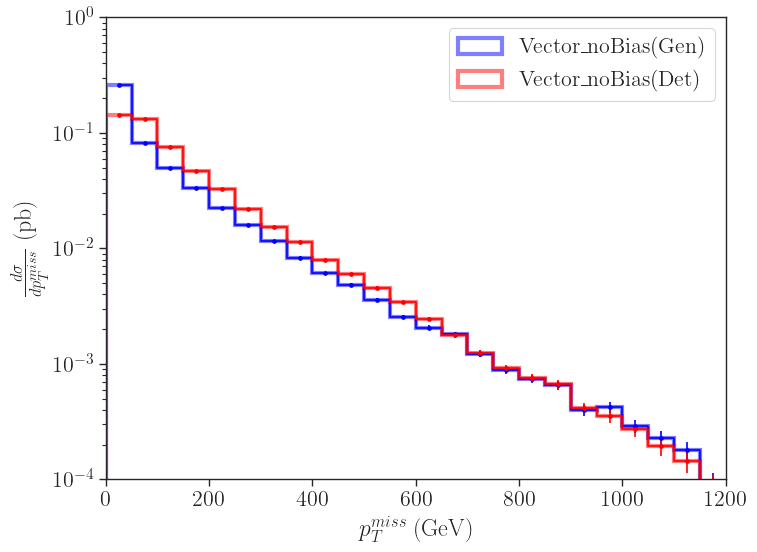

In [15]:
fig = plt.figure(figsize=(8,6))
plotError = True

        
for label,genmetPts in genMet.items():
    metPts = met[label]
    if label == 'Vector_noBias':
        binc1,binEdges1,patches1 = plt.hist(genmetPts,bins=np.arange(0.,2000.,50.),
                                   label=label+'(Gen)',histtype='step',
                                   weights=weights[label],linewidth=3,alpha=0.5, color='blue')
        binc2,binEdges2,patches2 = plt.hist(metPts,bins=np.arange(0.,2000.,50.),
                                   label=label+'(Det)',histtype='step',
                                   weights=weights[label],linewidth=3,alpha=0.5, color='red')
    
        if plotError:
            errorc21,_ = np.histogram(genmetPts,bins=binEdges1,weights=weights[label]**2)
            errorc1 = np.sqrt(errorc21)
            binMid1 = (binEdges1[0:-1]+binEdges1[1:])/2.
            plt.errorbar(binMid1,binc1,yerr = errorc1, marker = '.', 
                         drawstyle = 'steps-mid', color='blue')
            
            errorc22,_ = np.histogram(metPts,bins=binEdges2,weights=weights[label]**2)
            errorc2 = np.sqrt(errorc2)
            binMid2 = (binEdges2[0:-1]+binEdges2[1:])/2.
            plt.errorbar(binMid2,binc2,yerr = errorc2, marker = '.', 
                         drawstyle = 'steps-mid', color='red')
        
plt.yscale('log')
plt.ylim(1e-4,1e0)
plt.xlabel(r'$p_T^{miss}$ (GeV)')
plt.ylabel(r'$\frac{d\sigma}{d p_T^{miss}}$ (pb)')
plt.xlim(0,1200)
plt.legend()
plt.show()

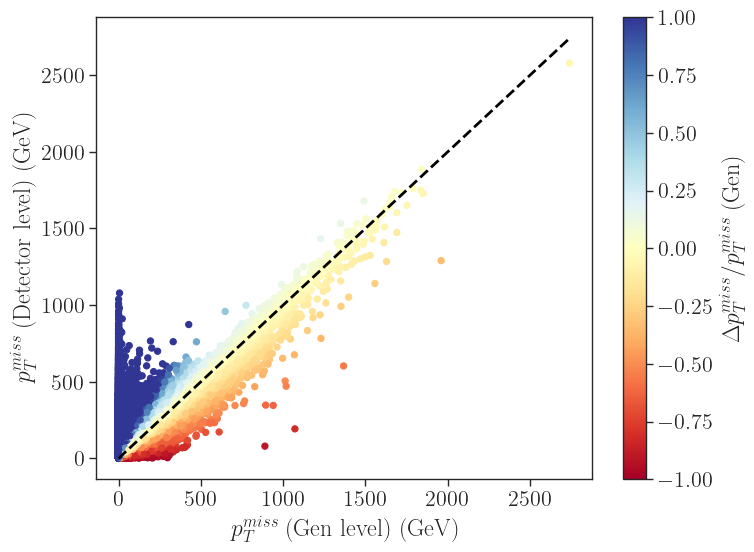

In [18]:
fig = plt.figure(figsize=(8,6))
for label,genmetPts in genMet.items():
    metPts = met[label]
    if label == 'Vector_noBias':
        diffRatio = (metPts-genmetPts)/genmetPts
        plt.scatter(genmetPts,metPts,s=20,cmap=cm,c=diffRatio,vmin=-1,vmax=1)
plt.plot([genmetPts.min(),genmetPts.max()],[genmetPts.min(),genmetPts.max()],
         linestyle='--',linewidth=2,c='black')
plt.colorbar(label=r'$\Delta p_T^{miss}/p_T^{miss}$ (Gen)')
plt.xlabel(r'$p_T^{miss}$ (Gen level) (GeV)')
plt.ylabel(r'$p_T^{miss}$ (Detector level) (GeV)')
plt.show()